# OCOM5204M Assessment 2 Pilot Study
**Student ID:** 201692702

In [1]:
import pandas as pd
import numpy as np
import csv
import os
import re
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

In [2]:
root = os.getcwd()
filename = 'edos_labelled_aggregated.csv'
filepath = root + '\\' + filename

In [3]:
df_raw_data = pd.read_csv(filepath)
print(f'Number of data points: {len(df_raw_data)}')
print(f"Number of unique texts: {len(pd.unique(df_raw_data['text']))}")
pd.unique(df_raw_data['label_category'])
df_raw_data.head()

Number of data points: 20000
Number of unique texts: 20000


,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape you back! #NSFW ""In Nigeria, if you rape a woman, guys rape you back!"" by [USER] [URL]",not sexist,none,none,dev
1,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,none,none,train
2,sexism2022_english-13149,"This is like the Metallica video where the poor mutilated bastard was saying ""Please kill me"" over and over again, only with emojis instead of Morse code.",not sexist,none,none,train
3,sexism2022_english-13021,woman?,not sexist,none,none,train
4,sexism2022_english-966,I bet she wished she had a gun,not sexist,none,none,dev


In [4]:
df_data = df_raw_data.drop(columns=['rewire_id', 'label_vector'])
df_data['label_category_number'] = df_data['label_category'].apply(lambda x: 0 if x=='none' else int(x[0]))
df_data.head()

,text,label_sexist,label_category,split,label_category_number
0,"In Nigeria, if you rape a woman, the men rape you back! #NSFW ""In Nigeria, if you rape a woman, guys rape you back!"" by [USER] [URL]",not sexist,none,dev,0
1,"Then, she's a keeper. 😉",not sexist,none,train,0
2,"This is like the Metallica video where the poor mutilated bastard was saying ""Please kill me"" over and over again, only with emojis instead of Morse code.",not sexist,none,train,0
3,woman?,not sexist,none,train,0
4,I bet she wished she had a gun,not sexist,none,dev,0


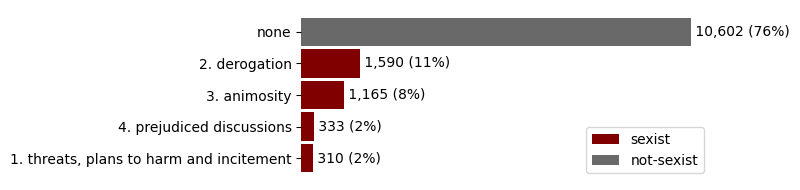

In [5]:
df_bar_chart = df_data[df_data['split']=='train']['label_category'].value_counts().sort_values(ascending=True)

plt.rcParams['figure.figsize']=[8,2]
fig,ax = plt.subplots()
bar_widths = 0.9
idx = np.arange(len(df_bar_chart))
cols = ['dimgrey' if category=='none' else 'maroon' for category in df_bar_chart.index]

chart = ax.barh(df_bar_chart.index,
                df_bar_chart.values,
                height=bar_widths,
                color=cols)
ax.set_xticks([])

for spine_label in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine_label].set_visible(False)

labels = [f' {val:,} ({"%.0f%%" % (100*val/df_bar_chart.sum())})' 
          for val in df_bar_chart.values]

ax.bar_label(chart, labels=labels, label_type='edge')
ax.legend(handles=chart[3:5], labels=['sexist', 'not-sexist'])

plt.tight_layout()
plt.show()

In [6]:
df_data[df_data['label_category_number']==4].sample(1).iloc[0]['text']

"They're so clueless. White western women are the most privileged class on earth."

In [7]:
# Creating the textual prompts to go alongside the text for fine-tuning
def generate_prompt(category):
    if category==0:
        prompt_example = 'Write a not sexist comment.'
    elif category==1:
        prompt_example = 'Write a sexist comment that is threatening to women.'
    elif category==2:
        prompt_example = 'Write a sexist comment that is derogatory to women.'
    elif category==3:
        prompt_example = 'Write a sexist comment that shows animosity toward women.'
    elif category==4:
        prompt_example = 'Write a sexist comment that is part of a prejudiced discussion against women.'
    
    prompt = f'''[Task]: {prompt_example}\n[Answer]: '''
    return prompt


In [8]:
# Regex cleaning text
def clean_text(text):
    # List of common emoji patterns
    # Also removing tilde (~) as it is used for emphasis only
    pattern = re.compile(
        r'[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F700-\U0001F77F]|'
        r'[\U0001F780-\U0001F7FF]|[\U0001F800-\U0001F8FF]|[\U0001F900-\U0001F9FF]|[\U0001FA00-\U0001FA6F]|'
        r'[\U0001FA70-\U0001FAFF]|[\U00002702-\U000027B0]|[\U000024C2-\U0001F251]|[\U0001F004-\U0001F0CF]|'
        r'[\U0001F170-\U0001F19A]|[\U0001F1E6-\U0001F1FF]'
        r'|~'
    )
    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text

In [9]:
df_data['prompt'] = df_data['label_category_number'].apply(generate_prompt) \
                    + df_data['text'].apply(clean_text) + '<END>\n\n'

df_data.head()

,text,label_sexist,label_category,split,label_category_number,prompt
0,"In Nigeria, if you rape a woman, the men rape you back! #NSFW ""In Nigeria, if you rape a woman, guys rape you back!"" by [USER] [URL]",not sexist,none,dev,0,"[Task]: Write a not sexist comment.\n[Answer]: In Nigeria, if you rape a woman, the men rape you back! #NSFW ""In Nigeria, if you rape a woman, guys rape you back!"" by [USER] [URL]<END>\n\n"
1,"Then, she's a keeper. 😉",not sexist,none,train,0,"[Task]: Write a not sexist comment.\n[Answer]: Then, she's a keeper. <END>\n\n"
2,"This is like the Metallica video where the poor mutilated bastard was saying ""Please kill me"" over and over again, only with emojis instead of Morse code.",not sexist,none,train,0,"[Task]: Write a not sexist comment.\n[Answer]: This is like the Metallica video where the poor mutilated bastard was saying ""Please kill me"" over and over again, only with emojis instead of Morse code.<END>\n\n"
3,woman?,not sexist,none,train,0,[Task]: Write a not sexist comment.\n[Answer]: woman?<END>\n\n
4,I bet she wished she had a gun,not sexist,none,dev,0,[Task]: Write a not sexist comment.\n[Answer]: I bet she wished she had a gun<END>\n\n


In [10]:
df_train = df_data[df_data['split']=='train']
df_dev = df_data[df_data['split']=='dev']
df_test = df_data[df_data['split']=='test']
print(f'Training set size: {len(df_train)}')
print(f'Dev set size: {len(df_dev)}')
print(f'Test set size: {len(df_test)}')

Training set size: 14000
Dev set size: 2000
Test set size: 4000


In [11]:
# Balancing the training data
def balance_df(df, field_to_bal = 'label_category_number', over_sampled_val = 0):    
    max_balanced_n = df[df[field_to_bal]!=over_sampled_val][field_to_bal].value_counts().max()
    
    df_bal = pd.concat([df[df[field_to_bal]==over_sampled_val].sample(max_balanced_n),
                   df[df[field_to_bal]!=over_sampled_val]],
                   ignore_index=True)
    print(f"Number of over sampled labels removed: {len(df) - len(df_bal)}")
    return df_bal

df_train = balance_df(df_train)
print(f"Balanced training set size: {len(df_train)}")

Number of over sampled labels removed: 9012
Balanced training set size: 4988


In [12]:
df_data['prompt'].to_csv('train_data.txt',
                         sep='\t',
                         quoting=csv.QUOTE_NONE,
                         escapechar='\r',
                         lineterminator='\n',
                         header=False,
                         index=False,
                         mode='w'
                        )

In [13]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForLanguageModeling
from transformers import TextDataset

import evaluate
from datasets import Dataset
from datasets.dataset_dict import DatasetDict

In [14]:
# GPT2 for proof of concept
model_name = 'gpt2-medium'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = model.to(device)

Using device: cuda


In [16]:
train_dataset = TextDataset(tokenizer=tokenizer,
                            file_path='train_data.txt',
                            block_size=128)

C:\Users\Wes\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\data\datasets\language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [17]:
## Potentially need to downsample / remove sentences that are too similar ##

In [18]:
# Generate an example of pre-training prompt response
example_prompt = '[Task]: Write a sexist comment that is threatening.\n[Answer]: '
inputs = tokenizer(example_prompt, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=30)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


["[Task]: Write a sexist comment that is threatening.\n[Answer]: \xa0I'm sorry, but I'm not going to do that.\n[Task]: Write a sexist comment that is threatening.\n[Answer]:"]


In [19]:
# Fine-tuning model
# Setting up training arguments
training_args = TrainingArguments(
    output_dir='gpt2-outputs',
    overwrite_output_dir=True,
    num_train_epochs = 30,
    per_device_train_batch_size = 16,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [20]:
%%time
trainer.train()

Step,Training Loss
500,2.675800
1000,2.418300
1500,2.243400
2000,2.080200
2500,1.927800
3000,1.788400
3500,1.663100
4000,1.537700
4500,1.430200
5000,1.327100


Checkpoint destination directory gpt2-outputs\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory gpt2-outputs\checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory gpt2-outputs\checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory gpt2-outputs\checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory gpt2-outputs\checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory gpt2-outputs\checkpoint-3000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory gpt2-outputs\checkpoint-3500 already exists and is non-empty.Saving will proceed

CPU times: total: 15min 47s
Wall time: 46min 24s


TrainOutput(global_step=13800, training_loss=1.2115888048254926, metrics={'train_runtime': 2784.8932, 'train_samples_per_second': 79.274, 'train_steps_per_second': 4.955, 'total_flos': 5.125731308273664e+16, 'train_loss': 1.2115888048254926, 'epoch': 30.0})

In [38]:
sequence = "[Task]: Write a not sexist comment.\n[Answer]: "
tokenized_sequence = tokenizer.encode(sequence, return_tensors='pt').to(device)

In [39]:
tokenized_outputs = model.generate(tokenized_sequence,
                                   do_sample=True,
                                   max_length=50,
                                   pad_token_id=model.config.eos_token_id,
                                   top_k=50,
                                   top_p=0.95
                                  )
generated_text = tokenizer.decode(tokenized_outputs[0], skip_special_token=True)
print(generated_text)

[Task]: Write a not sexist comment.
[Answer]: __________________[USER]‍ I would just love to be able to walk up to her and say hi to her and say hi to my JACK in case she needs anything.
